In [79]:
%pwd

'C:\\Users\\Srinjay\\Desktop\\mnist'

In [2]:
%mkdir mnist 

In [4]:
%cd mnist/
%pwd

C:\Users\Srinjay\Desktop\mnist


'C:\\Users\\Srinjay\\Desktop\\mnist'

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import rmsprop
from keras.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras import backend as K
K.set_image_dim_ordering('tf')

In [51]:
(X_train,Y_train),(X_test,Y_test)= mnist.load_data()

In [52]:
type(X_train)

numpy.ndarray

In [53]:
X_train.shape

(60000, 28, 28)

In [59]:
X_train.shape[0]

60000

In [60]:
X_test.shape

(10000, 28, 28)

In [54]:
print (Y_train[:4])

[5 0 4 1]


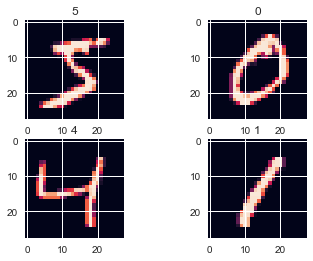

In [55]:
plt.subplot(221)
plt.title(Y_train[0])
plt.imshow(X_train[0])
plt.subplot(222)
plt.title(Y_train[1])
plt.imshow(X_train[1])
plt.subplot(223)
plt.title(Y_train[2])
plt.imshow(X_train[2])
plt.subplot(224)
plt.title(Y_train[3])
plt.imshow(X_train[3])
plt.show()

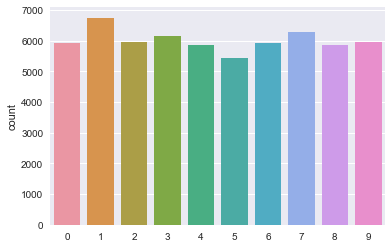

In [56]:
sns.set(style="darkgrid")
cnr = sns.countplot(Y_train)
plt.show()

In [45]:
X_train = X_train / 255
X_test = X_test / 255

In [48]:
X_train.max()

1.0

In [49]:
X_train.min()

0.0

In [57]:
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

In [58]:
Y_train[:4]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [65]:
size=28

In [66]:
X_train = X_train.reshape(X_train.shape[0], size, size,1)
X_test = X_test.reshape(X_test.shape[0], size, size,1)

In [67]:
X_train.shape

(60000, 28, 28, 1)

In [68]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
     self.val_f1s = []
     self.val_recalls = []
     self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
     val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
     val_targ = self.validation_data[1]
#      print(val_targ.shape)   
#      print(val_targ)
#      print(val_predict.shape)   
#      print(val_predict)   
     targ = []
     pred = []
     for x in val_targ:
        targ.append(np.argmax(x))
     for x in val_predict:
        pred.append(np.argmax(x))
#      print(targ)
#      print(pred)
        
     _val_f1 = f1_score(targ, pred)
     
     _val_recall = recall_score(targ, pred)
     _val_precision = precision_score(targ, pred)
     self.val_f1s.append(_val_f1)
     self.val_recalls.append(_val_recall)
     self.val_precisions.append(_val_precision)
     print("— val_f1: {0} — val_precision: {1} — val_recall {2} ".format(_val_f1, _val_precision, _val_recall))
     return

metrics = Metrics()

In [73]:
model = Sequential()
model.add(Conv2D(30, (5, 5), input_shape=(28, 28,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))

epochs = 25
lrate = 0.0001
decay = lrate/epochs
#sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
opt = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               48128     
__________

In [77]:
weight_saver = ModelCheckpoint('mnist_weights.h5', monitor='val_acc', save_best_only=True,save_weights_only=True)

In [91]:
history=model.fit(X_train, Y_train, batch_size=32, epochs=2, verbose=1, shuffle=True,validation_data=(X_test,Y_test),callbacks=[weight_saver])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 47s - loss: 0.1324 - acc: 0.9742 - val_loss: 0.0912 - val_acc: 0.9846
Epoch 2/2
60000/60000 [==============================] - 47s - loss: 0.1486 - acc: 0.9745 - val_loss: 0.1169 - val_acc: 0.9816


In [96]:
model.load_weights('mnist_weights.h5')

In [97]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

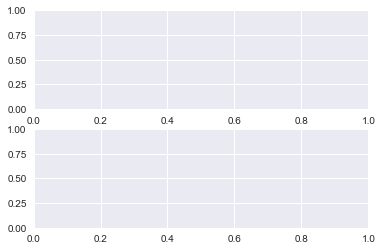

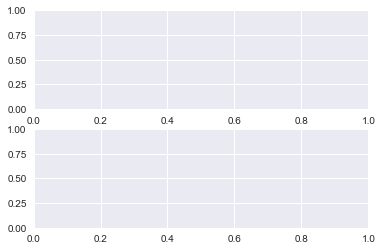

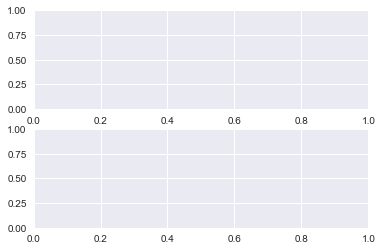

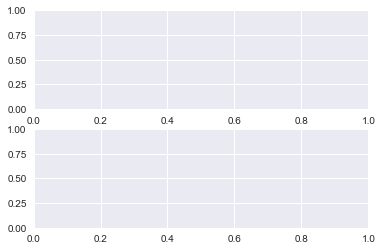

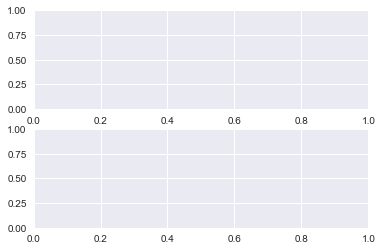

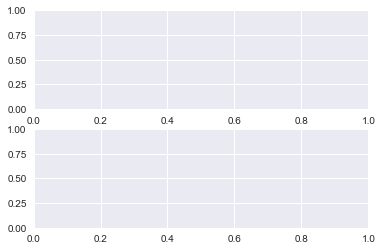

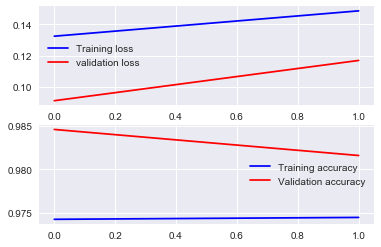

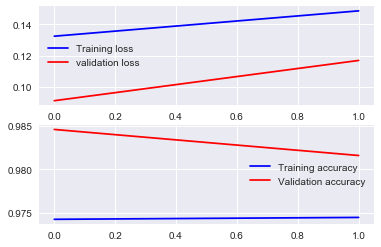

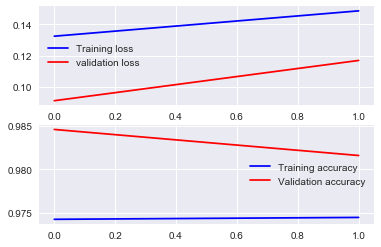

In [98]:
plt.show()

In [100]:
import itertools

In [110]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Y_pred = model.predict(X_test)
 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = range(10)) 


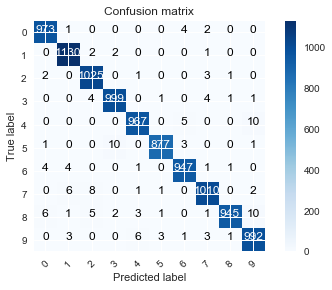

In [111]:
plt.figure(figsize=(40,40))
plt.show()